# Reset Networks - Topography on MNIST & CIFAR
**Objective**

Demonstrate the emergence of categorical areas in a CNN model, for MNIST and CIFAR10.

**Means**

Nested cortical model trained on MNIST and CIFAR10. <br>
Analyzing the responses of the model to faces, houses, objects and words.

Figure 1. (A) The cortex as a sequence of topographic spaces realized by nested deep neural networks (Nested Spatial networks, NS networks hereafter). At each level, a grid of deep neural networks shares the entire input from the level below. The output of the grid then becomes the input to the grid of networks at the next level.(B) A 2-fold NS network as a model of the ventral occipitotemporal cortex. When trained on the CIFAR 100 dataset augmented with words, categorical areas appear at level 1 of the NS.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image
import time
import numpy as np
from numpy.ma import masked_array
from scipy import ndimage
from scipy.signal import convolve2d as conv
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import sys, cv2
import pandas as pd
from sklearn.utils import shuffle

!pip install einops
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/')
from vit_pytorch import ViT, ViT_rec
from resnet import resnetSmall, resnet18, resnet34, resnet50, resnet101, resnet152 
from resnet_CIFAR10 import resnet20, hresnet20
from google.colab.patches import cv2_imshow

Simple CNN

Nested CNN for CIFAR

In [ ]:
class View(nn.Module):
  def __init__(self, shape):
    super(View, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)

In [ ]:
# Nested classifiers and autoencoder for CIFAR
class NestedCifar(nn.Module):
  def __init__(self, input_channels=3, h1_1=400, gridsize=8, n_classes1=16, n_classes2=10, drop_rate=0.2):
    super(NestedCifar, self).__init__()
    self.gridsize = gridsize
    self.n_classes1 = n_classes1
    self.sqrt_n_classes1 = int(n_classes1**0.5)
    self.Nest1 = nn.ModuleList([resnet20(num_channels=input_channels, num_classes=n_classes1) for i in np.arange(self.gridsize**2)])
    #self.Nest1 = nn.ModuleList([Simple(n_channels=input_channels, conv1k=3, conv2k=3, h1=64, n_classes=n_classes1, drop_rate=0.3) for i in np.arange(self.gridsize**2)])
    #self.Classifier = Simple(n_channels=1, conv1k=3, conv2k=3, h1=64, n_classes=n_classes2)
    self.Classifier = resnet20(num_channels=1, num_classes=n_classes2)
    """
    o = output
    i = input
    p = padding
    k = kernel_size
    s = stride
    d = dilation
    o = [i + 2*p - k - (k-1)*(d-1)]/s + 1
    """
    """
    if self.sqrt_n_classes1*self.gridsize == 32:
      self.Decoder = nn.Sequential(
          #View((-1,32*32)),
          #nn.Linear(32*32, 32*32),
          #nn.ReLU(),
          View((-1,16*16,2,2)),
          nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
          nn.ReLU(),
			    nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  
          nn.ReLU(),
          nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
          nn.Sigmoid(),
          )
    """
    
    if self.sqrt_n_classes1*self.gridsize == 32:
      self.Decoder = nn.Sequential(
          View((-1,32*32)),
          nn.Linear(32*32, 500),
          nn.ReLU(),
          nn.Linear(500, 3*32*32),
          nn.Sigmoid(),
          #nn.Tanh(),
          View((-1,3,32,32)),
          )
    
    if self.sqrt_n_classes1*self.gridsize == 48:
      self.Decoder = nn.Sequential(
        # [batch, 24, 8, 8]
        nn.Conv2d(1, n_classes1//2, 3, stride=2, padding=4),  # [batch, 12, 16, 16]
              nn.ReLU(),
              nn.Conv2d(n_classes1//2, input_channels, 2, stride=1, padding=3),   # [batch, 3, 32, 32]
              nn.Sigmoid(),
          )
      
    if self.sqrt_n_classes1*self.gridsize == 80:
      self.Decoder = nn.Sequential(
        # [batch, 24, 8, 8]
        nn.Conv2d(1, 2, 3, stride=2, padding=4),  # [batch, 12, 16, 16]
              nn.ReLU(),
              nn.Conv2d(2, 2, 3, stride=2, padding=4),  # [batch, 12, 16, 16]
              nn.ReLU(),
              nn.Conv2d(2, input_channels, 2, stride=1, padding=4),   # [batch, 3, 32, 32]
              nn.Sigmoid(),
          )
    self.BN0 = nn.BatchNorm2d(num_features = 1)
    self.dropout = nn.Dropout(drop_rate)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
	
  def forward(self, x):
    level1 = [self.Nest1[i](x) for i in np.arange(self.gridsize**2)] #process input through all networks at level 1
    level1 = torch.stack(level1, dim=0)
    level1 = level1.permute(1,2,0)
    # reshape by patch (nested list comprehension probably more elegant)
    to_cat = []
    for j in np.arange(self.gridsize):
      to_cat += [torch.cat([level1[:,:,i].reshape(-1, 1, self.sqrt_n_classes1, self.sqrt_n_classes1) for i in np.arange(j*self.gridsize, (j+1)*self.gridsize)],3)]
    grid = torch.cat(to_cat, 2)
    #grid = self.sigmoid(grid)
    grid = self.tanh(grid)
    grid = self.dropout(grid)
    grid = self.BN0(grid)
    out_c = self.Classifier(grid)
    out_d = self.Decoder(grid) #process map through all networks at level 2 (here only one decoder)
    return grid, out_c, out_d

In [ ]:
#test NestedCifar
net = NestedCifar(input_channels=3, gridsize=1, n_classes1=32*32, n_classes2=10)
model_total_params = sum(p.numel() for p in net.parameters())
print('==> Model built. The model has ',model_total_params,'total parameters')   
x = torch.zeros(1, 3, 32, 32)
print ('x.size()', x.size())
grid, y_class, y_auto = net(x)
print(grid.size())
print(y_class.size())
print(y_auto.size())

==> Model built. The model has  2656640 total parameters
x.size() torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.Size([1, 10])
torch.Size([1, 3, 32, 32])


In [ ]:
# Nested classifiers for CIFAR
class NestedCifarNoDecoder(nn.Module):
  def __init__(self, input_channels=3, h1_1=400, gridsize=8, n_classes1=16, n_classes2=10, drop_rate=0.2):
    super(NestedCifarNoDecoder, self).__init__()
    self.gridsize = gridsize
    self.n_classes1 = n_classes1
    self.sqrt_n_classes1 = int(n_classes1**0.5)
    self.Nest1 = nn.ModuleList([resnet20(num_channels=input_channels, num_classes=n_classes1) for i in np.arange(self.gridsize**2)])
    self.Classifier = resnet20(num_channels=1, num_classes=n_classes2)
    self.BN0 = nn.BatchNorm2d(num_features = 1)
    self.dropout = nn.Dropout(drop_rate)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
	
  def forward(self, x):
    level1 = [self.Nest1[i](x) for i in np.arange(self.gridsize**2)] #process input through all networks at level 1
    level1 = torch.stack(level1, dim=0)
    level1 = level1.permute(1,2,0)
    # reshape by patch (nested list comprehension probably more elegant)
    to_cat = []
    for j in np.arange(self.gridsize):
      to_cat += [torch.cat([level1[:,:,i].reshape(-1, 1, self.sqrt_n_classes1, self.sqrt_n_classes1) for i in np.arange(j*self.gridsize, (j+1)*self.gridsize)],3)]
    grid = torch.cat(to_cat, 2)
    #grid = self.sigmoid(grid)
    grid = self.tanh(grid)
    grid = self.dropout(grid)
    grid = self.BN0(grid)
    out_c = self.Classifier(grid)
    return grid, out_c

## Setup model and dataset

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelname = 'ResNet20'
dataset = 'CIFAR10'
input_channels = 1 if dataset=='MNIST' else 3
print ('input_channels', input_channels)
h1_1 = 400
print ('h1_1', h1_1)
gridsize = 4
h1_2 = 64 if gridsize>10 else 16 

use_cuda = True
load_word_dataset = True
load_submodels=False
load_model=False
save_model=True
epochs = 50
lrate = 0.001

augment_data = True
train_batchsize = 50
num_workers = 0
test_batchsize = 100

n_classes1 = 8*8#400#36#100
n_classes = 10
drop_rate = 0.5

alpha = 0.5 #between 0 and 1. When applicable, importance of autoencoding loss over classification loss.

input_channels 3
h1_1 400


In [ ]:
def load_Model(checkpointpath=None, modelname=None, dataset=None, load_model=False,
               input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes):

  if 'NestedMnist' in modelname:
    net = NestedMnist(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Nested cortical networks for MNIST loaded')

  if 'NestedCifar' in modelname:
    net = NestedCifar(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Nested cortical networks for CIFAR loaded')

  if 'CifarNoDecoder' in modelname:
    net = NestedCifarNoDecoder(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Nested cortical networks (without autoencoder) for CIFAR loaded')

  if 'ResNet20' in modelname:
    net = hresnet20(num_channels=input_channels, num_classes=n_classes)
    print ('ResNet20 for CIFAR loaded')

  model_total_params = sum(p.numel() for p in net.parameters())
  print('==> Model built. The model has ',model_total_params,'total parameters')

  if load_model:
    #load the model
    state = torch.load(checkpointpath + modelname + dataset + 'best_ckpt.t7')
    keys = list(state['net'].keys()); print ('This network had', len(keys),'stored sets of parameters')
    if 'module.' in keys[0]:
      for name in keys:
        state['net'][name[7:]] = state['net'].pop(name)
    net.load_state_dict(state['net'])
    print ('Pretrained weights loaded')

  if load_submodels:
    #load pretrained submodel
    pretrained_dict = submodel.state_dict()
    
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys (remove key for last dense layer)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k is not 'fc2'}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(pretrained_dict)
  
  return net

net = load_Model(checkpointpath=checkpointpath, modelname=modelname, dataset=dataset, load_model=load_model)

ResNet20 for CIFAR loaded
==> Model built. The model has  269722 total parameters


Cifar-10 or MNIST

In [ ]:
if dataset == 'CIFAR10':
  if (modelname == 'Auto') or (modelname == 'AutoClass'): 
    transform = transforms.Compose(
      [transforms.Resize(32),
       transforms.ToTensor(),
       transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])
  else: 
    transform = transforms.Compose(
      [transforms.Resize(32),
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize,
                                            shuffle=True, num_workers=num_workers)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize,
                                          shuffle=False, num_workers=1)

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  class_total = [np.sum(np.array(trainset.targets) == i) for i in range(10)]
  weights = torch.Tensor(np.max(class_total)/np.array(class_total))
  print ('class weights:', weights)
  
  print ('CIFAR-10 loaded')
  
if dataset == 'MNIST':
  #!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
  #!tar -zxvf MNIST.tar.gz
  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

  trainset = torchvision.datasets.QMNIST(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize,
                                            shuffle=True, num_workers=num_workers)

  testset = torchvision.datasets.QMNIST(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize,
                                          shuffle=False, num_workers=1)

  classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  class_total = [np.sum(trainset.targets.numpy()[:,0] == i) for i in range(10)]
  weights = torch.Tensor(np.max(class_total)/np.array(class_total))
  print ('train class weights:', weights)

  print ('QMNIST loaded')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
class weights: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
CIFAR-10 loaded


## Training

Parallel computing

In [ ]:
# Parallel computing
device = torch.device("cuda" if use_cuda else "cpu")
print ('device:', device)
net.to(device)
net = torch.nn.DataParallel(net)
weights = weights.to(device)
GPUcount = torch.cuda.device_count()
if GPUcount == 0:
  print ('No GPU available.')
if GPUcount == 1:
  print ('One GPU available.')
if GPUcount > 1:
  print (GPUcount, 'GPUs are available.')
print ('GPU type:', torch.cuda.get_device_name())

device: cuda


NameError: ignored

In [ ]:
CombinedLoss = True
if CombinedLoss:# Define an optimizer and criterion for autoencoder and classfier
  criterionAuto = nn.BCELoss()
  criterionClass = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(net.parameters())

In [ ]:
Adam=True
if Adam:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(net.parameters(), lr=lrate)

Testing

In [ ]:
def test(net, testloader):
  net.eval()
  start = time.time()
  net.to(device)
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          #inputs = 2*(inputs - torch.min(inputs))/(torch.max(inputs) - torch.min(inputs))-1
          inputs, labels = inputs.to(device), labels.to(device)
          #inputs = inputs.permute(0,3,2,1)
          if 'Nested' in modelname:
            grid, outputs, _ = net(inputs)
          elif modelname in ['ViT']:
            outputs = net(inputs)
            grid = None
          elif modelname in ['ResNet20']:
            h, outputs = net(inputs)
            channels = h.size(0)
            rh = int(h.size(1)**0.5)
            grid = h.view(channels, 1, rh, rh)
          else:
            grid, outputs = net(inputs)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  testacc = 100 * correct / total
  print('Accuracy of the network on the ',total,'test images:',testacc)

  end = time.time()
  print('Test time:', time.strftime('%H:%M:%S', time.gmtime(end-start)))

  return grid, testacc 

In [ ]:
grid, testacc = test(net, testloader)
print (grid.size())

Accuracy of the network on the  10000 test images: 53.75
Test time: 00:00:02
torch.Size([100, 1, 8, 8])


Compute grid responses and output accuracies for all categories

In [ ]:
def compute_class_grid_CIFAR(grid, verbose=False):
  print (grid.size())
  gn, gc, gs, gs = grid.shape
  print ('gn, gc, gs, gs', gn, gc, gs, gs)
  class_correct = list(0. for i in np.arange(n_classes))
  class_total = list(0. for i in np.arange(n_classes))
  class_grid = np.zeros((n_classes, gs, gs))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          #images = 2*(images - torch.min(images))/(torch.max(images) - torch.min(images))-1
          images, labels = images.to(device), labels.to(device)
          if 'Nested' in modelname:
            grid, outputs, _ = net(images)
          elif modelname in ['ResNet20']:
            grid, outputs = net(images)
            channels = grid.size(0)
            rh = int(grid.size(1)**0.5)
            grid = grid.view(channels, 1, rh, rh)
          else:
            grid, outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          grid_data = grid.cpu().numpy().squeeze()

          for i, label in enumerate(labels):
              label = int(label.cpu().numpy())
              #print ('label', label)
              if gc > 1:
                class_grid[label] += np.mean(grid[i], axis=0)
              else:
                class_grid[label] += grid_data[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

  class_acc = np.zeros(n_classes)
  for i in np.arange(n_classes):
      class_acc[i] = 100 * class_correct[i] / class_total[i]
      if class_total[i] > 0:
        class_grid[i] = class_grid[i]/class_total[i]
      if verbose:
        print('%3d Accuracy of %5s : %2d %% (%5d / %5d)' % (i, classes[i], class_acc[i], class_correct[i], class_total[i]))
  return class_acc, class_grid

def compute_class_grid_MNIST(grid, verbose=False):
  print (type(grid))
  gn, gc, gs, gs = grid.shape
  print ('gn, gc, gs, gs', gn, gc, gs, gs)
  class_correct = list(0. for i in np.arange(n_classes))
  class_total = list(0. for i in np.arange(n_classes))
  class_grid = np.zeros((n_classes, gs, gs))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          if 'Nested' in modelname:
            grid, outputs, _ = net(images)
          else:
            grid, outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          grid_data = grid.cpu().numpy().squeeze()

          for i, label in enumerate(labels):
              label = int(label.cpu().numpy())
              if gc > 1:
                class_grid[label] += np.mean(grid[i], axis=0)
              else:
                class_grid[label] += grid_data[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
  class_acc = np.zeros(n_classes)
  print ('class_total', class_total)
  for i in np.arange(n_classes):
      class_acc[i] = 100 * class_correct[i] / class_total[i]
      if class_total[i] > 0:
        class_grid[i] = class_grid[i]/class_total[i]
      if verbose:
        print('%3d Accuracy of %5s : %2d %% (%5d / %5d)' % (i, classes[i], class_acc[i], class_correct[i], class_total[i]))
  return class_acc, class_grid
  
go_compute_class_grid = False
if go_compute_class_grid:
  class_acc, class_grid = compute_class_grid(grid, verbose=True)

Training

In [ ]:
start = time.time()
e_start = time.time()
ltrain, ltest = len(trainloader), len(testloader)
print ('number of mini-batches for training:', ltrain)
print ('mini-batch size:', train_batchsize)
print ('total number of training exemplars:', ltrain*train_batchsize)
print ('\nnumber of mini-batches for testing:', ltest)
print ('mini-batch size:', test_batchsize)

if load_model:
  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  last_epoch = len(test_acc_history)
  bestacc = np.max(test_acc_history)
  print ('saved metrics loaded')
else:
  test_acc_history = []
  class_acc_history = []
  class_grid_history = []
  last_epoch = 0
  bestacc = 0

test_every = ltrain//2
#test_every = 2*ltrain   #never test
print_every = ltrain//20
print ('we will test every:', test_every, 'mini-batches, meaning, every',test_every*train_batchsize,'training exemplars.')

# Initial testing before training.
grid, testacc = test(net, testloader)
test_acc_history += [testacc]
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)

if 'Cifar' in modelname:
  class_acc, class_grid = compute_class_grid_CIFAR(grid, verbose=False)
  class_acc_history += [class_acc]
  class_grid_history += [class_grid]
if 'Mnist' in modelname:
  class_acc, class_grid = compute_class_grid_MNIST(grid, verbose=False)
  class_acc_history += [class_acc]
  class_grid_history += [class_grid]

np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)

# Start training
net.train()
for epoch in np.arange(last_epoch + epochs): 
    print ('Epoch:', epoch) 
    running_loss = 0.0
    running_lossAuto = 0.0
    running_lossClass = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #inputs = 2*(inputs - torch.min(inputs))/(torch.max(inputs) - torch.min(inputs)) - 1
        inputs, labels = inputs.to(device), labels.to(device)
        #print ('labels.size()', labels.size())

        optimizer.zero_grad()
        if 'Nested' in modelname:
          grid, outputsClass, outputsAuto = net(inputs)
         
        elif modelname in ['ViT']:
            outputs = net(inputs)
        
        elif modelname in ['ResNet20']:
            grid, outputs = net(inputs)
            channels = grid.size(0)
            rh = int(grid.size(1)**0.5)
            grid = grid.view(channels, 1, rh, rh)
          
        else:
          grid, outputs = net(inputs)
          #print(outputs.size())

        if modelname == 'Auto':
          loss = criterion(outputs, inputs)

        if 'Nested' in modelname:
          lossAuto = criterionAuto(outputsAuto, inputs);running_lossAuto = lossAuto.item()
          lossAuto = 2 + lossAuto/50  #this loss appears to be bounded by [0 -50]
          
          lossClass = criterionClass(outputsClass, labels.long());running_lossClass = lossClass.item()
          lossClass = lossClass/3      #this loss appears to b bounded by [3, 0]
          #print ('lossAuto.item()', lossAuto.item())
          #print ('lossClass.item()', lossClass.item())
          loss = alpha*lossAuto + (1-alpha)*lossClass
          #print ('loss.item()', loss.item())
        
        else:
          loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i != 0) & (i % print_every == 0):    # print
          if 'Nested' in modelname:
            print ('[batch %3d] reconstruction loss: %.3f, classif loss:%.3f, combined scaled loss: %.3f' % (i, lossAuto.item(), lossClass.item(), loss.item()))
          else:
            print ('[batch %3d] classif loss:%.3f' % (i, loss.item()))

        if (i != 0) & (i % test_every == 0):    # test 
            e_end = time.time()
            print('\n\nTraining time:', time.strftime('%H:%M:%S', time.gmtime(e_end - e_start)))
            e_start = time.time()

            if 'Nested' in modelname:
              autoloss = np.round(running_lossAuto / test_every, decimals=3)
              classloss = np.round(running_lossClass / test_every, decimals=3)
              closs = running_loss / test_every
              print('[%d, %5d] reconstruction loss: %.3f, classif loss:%.3f, combined scaled loss: %.3f' % (epoch + 1, i + 1, autoloss, classloss, closs))
            else:
              closs = running_loss / test_every
              print('[%d, %5d] classif loss:%.3f' % (epoch + 1, i + 1, closs))

            running_loss = 0.0
            _, testacc = test(net, testloader)
            test_acc_history += [testacc]

            if ('Cifar' in modelname) or ('ResNet' in modelname):
              class_acc, class_grid = compute_class_grid_CIFAR(grid, verbose=False)
              class_acc_history += [class_acc]
              class_grid_history += [class_grid]
            if 'Mnist' in modelname:
              class_acc, class_grid = compute_class_grid_MNIST(grid, verbose=False)
              class_acc_history += [class_acc]
              class_grid_history += [class_grid]

            np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
            net.train()

            if testacc > bestacc:
              print ('saving as best model')
              state = {'net': net.state_dict(),}
              torch.save(state, checkpointpath + modelname + dataset + 'best_ckpt.t7')
              bestacc = testacc
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
end = time.time()
print('Done training. Total training time:')
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

number of mini-batches for training: 1000
mini-batch size: 50
total number of training exemplars: 50000

number of mini-batches for testing: 100
mini-batch size: 100
we will test every: 500 mini-batches, meaning, every 25000 training exemplars.
Accuracy of the network on the  10000 test images: 9.93
Test time: 00:00:04
Epoch: 0
[batch  50] classif loss:1.909
[batch 100] classif loss:1.833
[batch 150] classif loss:1.677
[batch 200] classif loss:1.955
[batch 250] classif loss:1.934
[batch 300] classif loss:1.520
[batch 350] classif loss:1.666
[batch 400] classif loss:1.765
[batch 450] classif loss:1.441
[batch 500] classif loss:1.366


Training time: 00:00:24
[1,   501] classif loss:1.667
Accuracy of the network on the  10000 test images: 49.13
Test time: 00:00:04
torch.Size([50, 1, 8, 8])
gn, gc, gs, gs 50 1 8 8
saving as best model
[batch 550] classif loss:1.348
[batch 600] classif loss:1.250
[batch 650] classif loss:1.624
[batch 700] classif loss:1.382
[batch 750] classif loss:1.503
[

# Various Tests

Clustering index, density index

Plot all clusters on one map

In [ ]:
def common_map(class_grid_history=None, class_acc_history=None, epoch=0, save=False, show=True):
  from numpy.ma import masked_array
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt
  import matplotlib.patches as patches
  from matplotlib.patches import Rectangle
  from matplotlib import gridspec

  titles = classes
  maps = ['Reds', 'Greens', 'Blues', 'Purples', 'binary','Reds', 'Greens', 'Blues', 'Purples', 'binary']
  colors = ['red', 'green', 'blue', 'purple', 'black', 'red', 'green', 'blue', 'purple', 'black']
  epochs, c, x, y = class_grid_history.shape
  targets_data = np.zeros((n_classes, x, y))
  #indices of target classes:
  ranges = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
  x_ranges = [[1, 2, 3, 4, 5, 6, 7, 8, 9], 
              [0, 2, 3, 4, 5, 6, 7, 8, 9],
              [0, 1, 3, 4, 5, 6, 7, 8, 9],
              [0, 1, 2, 4, 5, 6, 7, 8, 9],
              [0, 1, 2, 3, 5, 6, 7, 8, 9],
              [0, 1, 2, 3, 4, 6, 7, 8, 9],
              [0, 1, 2, 3, 4, 5, 7, 8, 9],
              [0, 1, 2, 3, 4, 5, 6, 8, 9],
              [0, 1, 2, 3, 4, 5, 6, 7, 9],
              [0, 1, 2, 3, 4, 5, 6, 7, 8]]
  all_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  l = len(titles)
  T = 0.85 #significance threshold for sensitivity measure
  gf_sigma = 2.0
  class_grid = gaussian_filter(class_grid_history[epoch], sigma = gf_sigma)   # smoothing
  #class_grid = (class_grid - np.min(class_grid))/(np.max(class_grid) - np.min(class_grid)) # rescaling
  #fig, ax = plt.subplots(figsize=(20, 10))
  fig = plt.figure(figsize=(20, 15)) 
  gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[100, 1]) 

  ax0 = plt.subplot(gs[0])
  suptitle = 'vOTC epoch '+str(epoch)
  plt.title(suptitle, size=20)
  plt.tick_params(
          axis='x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=False) # labels along the bottom edge are off
  plt.tick_params(
          axis='y',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          right=False,         # ticks along the top edge are off
          labelleft=False) # labels along the bottom edge are off
  
  density = np.zeros(l)
  clustering = np.zeros(l)
  target_acc = np.zeros(l)
  for i, (title, range, x_range, map) in enumerate(zip(titles, ranges, x_ranges, maps)):
    # average test accuracy for that class at that epoch
    target_acc[i] = np.mean(class_acc_history[epoch, range])
    mean_tar = np.mean(class_grid[range], axis=0)           # average over target classes
    std_tar = np.var(class_grid[range], axis=0)**0.5        # std over target classes
    mean_xtar = np.mean(class_grid[x_range], axis=0)        # average over excluded classes
    std_xtar = np.var(class_grid[x_range], axis=0) **0.5    # std over excluded classes
    std = (std_tar + std_xtar)/2.0
    #data = np.abs(mean_tar - mean_xtar)/std
    data = (mean_tar - mean_xtar)/std
    data = (data - np.min(data))/(np.max(data) - np.min(data)) # rescaling
    data_ma = masked_array(data, data < T)
    im = ax0.imshow(data_ma, alpha=0.7, cmap=plt.get_cmap(map))
    targets_data[i] = data
    # clustering index
    clustering[i] = clustering_index(class_grid=data, kernel_size=3)
    # density index
    density[i] = density_index(class_grid=data)

  ax1 = plt.subplot(gs[1])
  plt.axis('off')
      
  for i, (cat, color) in enumerate(zip(titles, colors)):
    # Create a Rectangle patch
    rect = patches.Rectangle((0.2, 0.4 + i/12.0),0.1,0.05,linewidth=1,edgecolor=color,facecolor=color)

    # Add the patch to the Axes
    ax1.add_patch(rect)

    # Annotate
    ax1.annotate(cat, (0.2, 0.4 + i/12.0), (0.4, 0.41 + i/12.0), size=15)

  cbaxes = plt.subplot(gs[2])
  cb = plt.colorbar(im, cax = cbaxes, shrink=0.5, orientation='horizontal')  
  cb.set_label('normalized sensitivity', size=20)

  if save:
    plt.savefig(checkpointpath + suptitle+'_' + modelname + dataset + str(epoch) + '.png')

  if show:
    plt.show()
    
  plt.clf()
  del fig
  
  return targets_data, clustering, density, target_acc

go_common_map = False
if go_common_map:
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  print ('class_acc_history.shape',class_acc_history.shape)
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  print ('class_grid_history.shape',class_grid_history.shape)
  targets_data, clustering, density, target_acc = common_map(class_grid_history=class_grid_history, epoch=3)

Generate metrics

In [ ]:
# load data history
class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
print ('class_acc_history.shape',class_acc_history.shape)
class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
print ('class_grid_history.shape',class_grid_history.shape)

n_epochs,n_classes,x,y = np.shape(class_grid_history)
print ('n_epochs,n_classes,x,y', n_epochs,n_classes,x,y)
target_maps_history = np.zeros((n_epochs, n_classes, x, y))
clustering_history = np.zeros((n_epochs, n_classes))
density_history = np.zeros((n_epochs, n_classes))
target_acc_history = np.zeros((n_epochs, n_classes))
for epoch in range(n_epochs):
  targets_data, clustering, density, target_acc = common_map(class_grid_history=class_grid_history, class_acc_history=class_acc_history, epoch=epoch, save=False, show=False)
  target_maps_history[epoch] = targets_data
  clustering_history[epoch] = clustering
  density_history[epoch] = density
  target_acc_history[epoch] = target_acc

np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)

class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 10 32 32


NameError: ignored

Animated version

test_acc_history.shape (51,)
target_acc_history.shape (51, 10)
target_data_history.shape (51, 10, 32, 32)
density_history.shape (51, 10)
clustering_history.shape (51, 10)
describe(target_data_history) DescribeResult(nobs=522240, minmax=(0.0, 1.0), mean=0.4978681680543143, variance=0.06517344186856355, skewness=0.0599387597554733, kurtosis=-1.0945051236507926)
describe(clustering_history) DescribeResult(nobs=510, minmax=(0.0, 0.9445293985253176), mean=0.6891647512708128, variance=0.13749527437605272, skewness=-1.3140936961990475, kurtosis=-0.251978827155694)
describe(density_history) DescribeResult(nobs=510, minmax=(0.0009765625, 0.3779296875), mean=0.09928576899509804, variance=0.011431266840950145, skewness=1.0519499295377641, kurtosis=-0.26813333221991176)
describe(data) DescribeResult(nobs=1024, minmax=(0.0, 1.0), mean=0.46416496732578705, variance=0.07110529452956692, skewness=0.05351447457495514, kurtosis=-1.495104402373001)


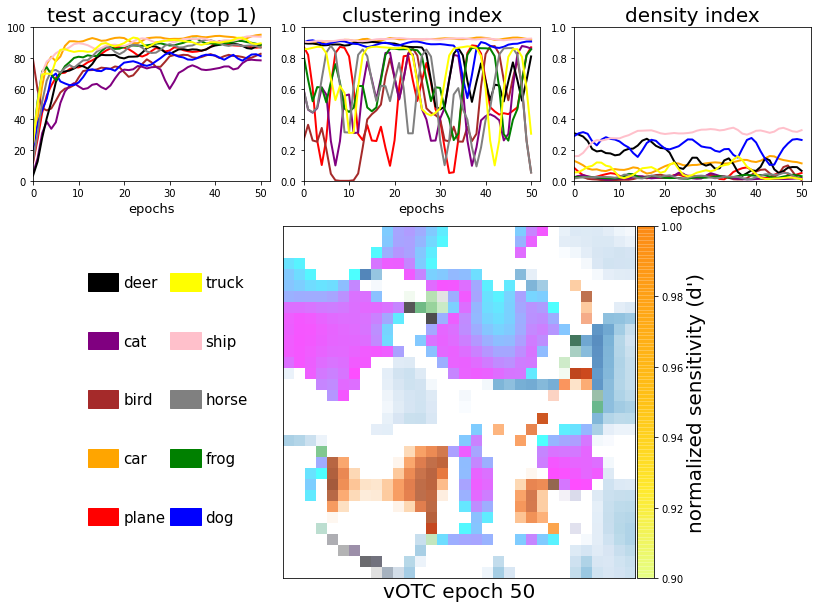

In [ ]:
def animate_monitor(save=True):
  import numpy as np
  from numpy.ma import masked_array
  import matplotlib.pyplot as plt
  from matplotlib import animation, rc
  from IPython.display import HTML
  from scipy.stats import describe

  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  target_acc_history = np.load(checkpointpath + modelname + dataset + 'target_acc_history.npy')
  target_data_history = np.load(checkpointpath + modelname + dataset + 'target_maps_history.npy') 
  density_history = np.load(checkpointpath + modelname + dataset + 'density_history.npy')
  clustering_history = np.load(checkpointpath + modelname + dataset + 'clustering_history.npy')
  epoch, n, x, y = target_data_history.shape
  
  print ('test_acc_history.shape', test_acc_history.shape)
  print ('target_acc_history.shape', target_acc_history.shape)
  print ('target_data_history.shape', target_data_history.shape)
  print ('density_history.shape', density_history.shape)
  print ('clustering_history.shape', clustering_history.shape)
  print ('describe(target_data_history)', describe(np.ravel(target_data_history)))
  print ('describe(clustering_history)', describe(np.ravel(clustering_history)))
  print ('describe(density_history)', describe(np.ravel(density_history)))

  epochs = np.arange(epoch)
  nans = np.nan*np.zeros(epoch)
  acc_lines, clu_lines, den_lines = n*[[]], n*[[]], n*[[]]
  images = n*[[]]

  if dataset == 'CIFAR10':
    titles = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    maps = ['Reds', 'Oranges', 'YlOrBr', 'Purples', 'binary', 'Blues', 'Greens', 'Greys', 'cool', 'Wistia']
    colors = ['red', 'orange', 'brown', 'purple', 'black', 'blue', 'green', 'gray', 'pink', 'yellow']
  if dataset == 'MNIST':
    titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    maps = ['Reds', 'Blues', 'Greens', 'YlOrBr', 'binary','Greys', 'Oranges', 'Purples', 'Wistia', 'cool']
    colors = ['red', 'blue', 'green', 'brown', 'black', 'gray', 'orange', 'purple', 'yellow', 'pink']
  l = len(titles)

  fig = plt.figure(figsize=(12, 9)) 
  ncols, nrows = 12, 12
  gs = gridspec.GridSpec(nrows, ncols, left=0.05, bottom=0.05, right=0.95, top=0.90, wspace=1, hspace=10)
  # Add axes which can span multiple grid boxes
  ax0 = fig.add_subplot(gs[:4, :4])
  ax1 = fig.add_subplot(gs[:4, 4:8])
  ax2 = fig.add_subplot(gs[:4, 8:12])
  ax3 = fig.add_subplot(gs[4:, :11])

  ax0.set_title('test accuracy (top 1)', size=20)
  ax0.set_xlabel('epochs', size=13) 
  ax0.set_xlim(0, epoch+1)
  ax0.set_ylim(0,100) 
  ax1.set_title('clustering index', size=20)
  ax1.set_xlabel('epochs', size=13)
  ax1.set_xlim(0,epoch+1)
  ax1.set_ylim(0,1) 
  ax2.set_title('density index', size=20)
  ax2.set_xlabel('epochs', size=13)
  ax2.set_xlim(0,epoch+1)
  ax2.set_ylim(0,1) 
  ax3.set_title('vOTC epoch 0', size=20, y=-0.07)
  ax3.tick_params(
          axis='x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=False) # labels along the bottom edge are off
  ax3.tick_params(
          axis='y',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          right=False,         # ticks along the top edge are off
          labelleft=False) # labels along the bottom edge are off
  
  T = 0.90 #sensitivity threshold
  smooth = True
  if smooth:
    target_acc_history = ndimage.gaussian_filter1d(target_acc_history, 1, axis=0)
    clustering_history = ndimage.gaussian_filter1d(clustering_history, 1, axis=0)
    density_history = ndimage.gaussian_filter1d(density_history, 1, axis=0)

  for i, (title, map, color) in enumerate(zip(titles, maps, colors)):
    # plot: accuracy
    acc_lines[i], = ax0.plot([], [], color=color, lw=2)
    # plot: clustering
    clu_lines[i], = ax1.plot(clustering_history[:, i], color=color, lw=2)
    # plot: density
    den_lines[i], = ax2.plot(density_history[:, i], color=color, lw=2)
    # plot: common map
    data = masked_array(target_data_history[0, i], target_data_history[0, i] < T)
    images[i] = ax3.imshow(data, alpha=0.7, cmap=plt.get_cmap(map), vmin=T, vmax=1)
   
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  divider = make_axes_locatable(ax3)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cax.axis('off')
  print ('describe(data)', describe(np.ravel(data)))
  cb = plt.colorbar(images[-1], ax=cax)
  cb.set_label("normalized sensitivity (d')", size=20)

  axleg = divider.append_axes("left", size="35%", pad=1)
  for i, (cat, color) in enumerate(zip(titles, colors)):
    # Create a Rectangle patch
    rect = patches.Rectangle((0 + (i//5)/1.5, 0.15 + (i%5)/6.0), 0.25, 0.05, linewidth=1, edgecolor=color, facecolor=color)

    # Add the patch to the Axes
    axleg.add_patch(rect)

    # Annotate
    axleg.annotate(cat, (0.29 + (i//5)/1.5, 0.16 + (i%5)/6.0), (0.29 + (i//5)/1.5, 0.16 + (i%5)/6.0), size=15)
  axleg.axis('off')

  # initialization function: plot the background of each frame
  def init():
    for i in range(l):
      acc_lines[i].set_data([], [])
      clu_lines[i].set_data([], [])
      den_lines[i].set_data([], [])
      images[i].set_array(target_data_history[0, i])
    return acc_lines+images
  
  # animation function. This is called sequentially  
  def animate(t):
    ax3.clear()
    ax3.set_title('vOTC epoch '+str(t), size=20, y=-0.07)
    for i, map in enumerate(maps):
      acc_lines[i].set_data(epochs[:t+1], target_acc_history[:t+1, i])
      clu_lines[i].set_data(epochs[:t+1], clustering_history[:t+1, i])
      den_lines[i].set_data(epochs[:t+1], density_history[:t+1, i])
      update_data = masked_array(target_data_history[t, i], target_data_history[t, i] < T)
      images[i] = ax3.imshow(update_data, alpha=0.7, cmap=plt.get_cmap(map), vmin=T, vmax=1)
    return acc_lines+clu_lines+den_lines+images

  frames = np.min((100, epoch))
  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=True)

  if save:
    anim.save(filename='history_monitor_'+dataset+'.mp4', fps=10, dpi=300)

  # Note: below is the part which makes it work on Colab
  rc('animation', html='jshtml')
  return anim

anim = animate_monitor()

## With focus

In [ ]:
def clustering_index2(data, threshold=0.85, connectivity=4):
  den_index = np.sum(data)
  data = (data > threshold).astype(np.uint8)
  # Thresholding
  ret, thresh = cv2.threshold(data,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # Choose 4 or 8 for connectivity type
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
  clu_index = np.mean(stats[1:,-1])
  #select_clu_index = np.mean([cc for cc in stats[1:,-1] if cc>connectivity])
  select_clu_index = np.sum([1 for cc in stats[1:,-1] if cc>connectivity])
  return num_labels, labels, clu_index, select_clu_index, den_index

load=True
if load:
  checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
  #modelname = 'CifarNoDecoder2_32'
  modelname = 'NestedCifar2_32'
  dataset = 'CIFAR10'
  target_maps_history = np.load(checkpointpath + modelname + dataset + 'target_maps_history.npy')
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')

print ('target_maps_history.shape',target_maps_history.shape)

#test 1
epoch=1
T=0.85
connectivity = 8 
cat = 1 
data = target_maps_history[epoch,cat]
act_data = class_grid_history[epoch,cat]
num_labels, labels, clu_index, select_clu_index, den_index = clustering_index2(data, threshold=T, connectivity=connectivity)

plt.subplot(131);plt.title('d-prime map');plt.imshow(data);plt.axis('off')
plt.subplot(132);plt.title('thresholded');plt.imshow(data > T);plt.axis('off')
plt.subplot(133);plt.title('connected');plt.imshow(labels);plt.axis('off')
plt.savefig('connected components', dpi=300)
plt.show()
print ('category:', cat)
print ('epoch:', epoch)
print ('connected components:', num_labels-1)
print ('clustering index:', clu_index)
print ('select clustering index:', select_clu_index)

#test 2
l = len(target_maps_history)
clu_indices = np.zeros(l)
select_clu_indices = np.zeros(l)
den_indices = np.zeros(l)
for epoch, (map, act_map) in enumerate(zip(target_maps_history, class_grid_history)):
  num_labels, labels, clu_index, select_clu_index, den_index = clustering_index2(map[cat], threshold=T, connectivity=connectivity)
  clu_indices[epoch] = clu_index
  select_clu_indices[epoch] = select_clu_index
  den_indices[epoch] = np.mean(act_map)

plt.subplot(131)
plt.plot(clu_indices)
plt.subplot(132)
plt.plot(select_clu_indices)
plt.subplot(133)
plt.plot(den_indices)

NameError: ignored

Show the totality of operations in order to produce a sensitivity map.

In [ ]:
def plot_pipeline(data):
  [cat1, cat2, mean1, mean2, smean1, smean2, dmap, labels, clu_index] = data
  s = 10
  plt.subplot(251)
  plt.imshow(mean1)
  plt.xticks([])
  plt.yticks([])
  plt.title('averaged', size=s)
  plt.ylabel(cat1, size=s)

  plt.subplot(252)
  plt.imshow(smean1)
  plt.xticks([])
  plt.yticks([])
  plt.title('smoothed', size=s)

  plt.subplot(256)
  plt.imshow(mean2)
  plt.xticks([])
  plt.yticks([])
  plt.ylabel(cat2, size=s)

  plt.subplot(257)
  plt.imshow(smean2)
  plt.xticks([])
  plt.yticks([])

  plt.subplot(153)
  im = plt.imshow(dmap)
  plt.xticks([])
  plt.yticks([])
  plt.title('d-primed', size=s)
  plt.ylabel(cat1 + '\n-\n' + cat2, rotation=0, labelpad=22, y=0.2)
  #plt.colorbar(im,fraction=0.046, pad=0.04)

  plt.subplot(154)
  plt.title('thresholded', size=s)
  plt.imshow(dmap > T)
  plt.axis('off')

  plt.subplot(155)
  plt.title('connected', size=s)
  plt.imshow(labels)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel('mean cluster size \n= '+str(np.round(clu_index, 2)))

  plt.savefig('pipeline'+modelname+'.png', dpi=300)
  plt.show()

def compute_pipeline(select1, select2, T = 1, connectivity = 8, gf_sigma=0):
  # compute d-prime sensitivity measure at each point of the grid
  mean1 = np.mean(select1, axis=0)
  mean2 = np.mean(select2, axis=0)
  std1 = np.var(select1, axis=0)**0.5
  std2 = np.var(select2, axis=0)**0.5

  # possibly smooth activations
  gf_sigma = 0#.5
  smean1 = gaussian_filter(mean1, sigma = gf_sigma)   # smoothing
  smean2 = gaussian_filter(mean2, sigma = gf_sigma)   

  # compute d-prime map
  dmap = 2*(smean1 - smean2)/(std1 + std2)

  # compute clustering index

  num_labels, labels, clu_index, select_clu_index, den_index = clustering_index2(dmap, threshold=T, connectivity=connectivity)

  data = [mean1, mean2, smean1, smean2, dmap, labels, clu_index]
  
  return data

def compute_pipeline2(select1, select2, T = 1, connectivity = 8, gf_sigma=0):
  # compute d-prime sensitivity measure at each point of the grid
  mean1 = np.mean(select1, axis=0)
  mean2 = np.mean(select2, axis=0)
  std1 = np.var(select1, axis=0)**0.5
  std2 = np.var(select2, axis=0)**0.5

  # possibly smooth activations
  gf_sigma = 0#.5
  smean1 = gaussian_filter(mean1, sigma = gf_sigma)   # smoothing
  smean2 = gaussian_filter(mean2, sigma = gf_sigma)   

  # compute d-prime map
  dmap = 2*(smean1 - smean2)/(std1 + std2)

  # compute clustering index

  num_labels, labels, clu_index, select_clu_index, den_index = clustering_index2(dmap, threshold=T, connectivity=connectivity)

  targets_data = dmap > T
  clustering = clu_index
  density = smean1 + smean2
  return targets_data, clustering, density



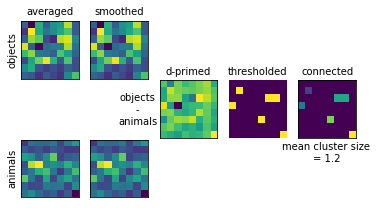

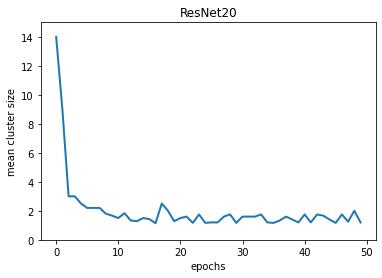

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelname = 'ResNet20'#'CifarNoDecoder4_32'#'NestedCifar4_32'#'CifarNoDecoder4_32'#'ResNet20'#
dataset = 'CIFAR10'

# load activations on the grid for each class
class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')

# possibly rescale activations across all classes and all epochs, to [0, 1]
class_grid_history = (class_grid_history - np.min(class_grid_history))/(np.max(class_grid_history) - np.min(class_grid_history))

# consider a contrast between two sets of classes, here animals vs objects
set2 = np.array([2, 3, 4, 5, 6, 7]);cat2 = 'animals' 
set1 = np.array([0, 1, 8, 9]);cat1 = 'objects'

# compute pipeline for some epochs, threshold, connectivity and smoothing std
epochs = np.arange(50)
T = 2
connectivity = 4
gf_sigma = 0
c_indices = np.zeros(50)
for i, epoch in enumerate(epochs):
  select1 = class_grid_history[epoch, set1]
  select2 = class_grid_history[epoch, set2]
  data = compute_pipeline(select1, select2, T = T, connectivity = connectivity, gf_sigma=gf_sigma)
  c_indices[i] = data[-1] 

plot=True
if plot:
  plot_pipeline([cat1, cat2]+data)

plt.plot(c_indices, lw=2);plt.xlabel('epochs');plt.ylim(0,int(np.max(c_indices))+1);plt.ylabel('mean cluster size');plt.title(modelname)
plt.savefig('clustering evolution'+modelname+'.png', dpi=300)
plt.show()

In [ ]:
def compute_save_metrics(modelname=None, dataset=None, T=0.95, S=0.5):
  # load data history
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  print ('class_acc_history.shape',class_acc_history.shape)
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  print ('class_grid_history.shape',class_grid_history.shape)

  # compute maps and indices
  n_epochs,_,x,y = np.shape(class_grid_history)
  n_classes = 2
  print ('n_epochs,n_classes,x,y', n_epochs,n_classes,x,y)
  target_maps_history = np.zeros((n_epochs, n_classes, x, y))
  clustering_history = np.zeros((n_epochs, n_classes))
  density_history = np.zeros((n_epochs, n_classes))
  target_acc_history = np.zeros((n_epochs, n_classes))
  for epoch in range(n_epochs):
    targets_data, clustering, density, target_acc = common_map_focus(T=T, S=S, class_grid_history=class_grid_history, class_acc_history=class_acc_history, epoch=epoch, save=False, show=False)
    target_maps_history[epoch] = targets_data
    clustering_history[epoch] = clustering
    density_history[epoch] = density
    target_acc_history[epoch] = target_acc

  #save
  np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
  np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
  np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
  np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)

In [ ]:
from scipy.signal import convolve2d as conv
import numpy as np

def clustering_index(class_grid=None, kernel_size=3, threshold=0.85):
  kernel = np.ones((kernel_size, kernel_size))/(kernel_size**2)
  s = class_grid.shape

  if len(s) == 3:
    cluster_indices = np.zeros(s[0])
    for i, grid in enumerate(class_grid):
      conv_map = conv(grid, kernel, mode='valid')
      above_threshold = np.sum(conv_map>threshold)
      if above_threshold != 0:
        cluster_indices[i] = np.sum(conv_map)/above_threshold
      else:
        cluster_indices[i] = 0
    return cluster_indices

  if len(s) == 2:
    conv_map = conv(class_grid, kernel, mode='valid')
    indices_above_threshold = (conv_map>threshold)
    num_above_threshold = np.sum(indices_above_threshold)
    sum_above_threshold = np.sum(conv_map[indices_above_threshold])
    if num_above_threshold != 0:
      return sum_above_threshold/num_above_threshold
    else: 
      return 0

def clustering_index2(data, threshold=0.85):
  data = (data > threshold).astype(np.uint8)
  
  # Thresholding
  ret, thresh = cv2.threshold(data,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # Choose 4 or 8 for connectivity type
  connectivity = 8  
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
  clu_index = np.mean(stats[1:,-1])
  return labels, clu_index

def density_index(class_grid=None, threshold=0.85):
  s = class_grid.shape
  return np.mean(class_grid > threshold, axis=(-2,-1))

class_grid_history.shape (50, 10, 8, 8)
class_grid_history.shape (51, 10, 32, 32)
class_grid_history.shape (51, 10, 32, 32)
class_grid_history.shape (51, 10, 32, 32)
class_grid_history.shape (51, 10, 32, 32)
class_grid_history.shape (51, 10, 32, 32)
class_grid_history.shape (51, 10, 32, 32)


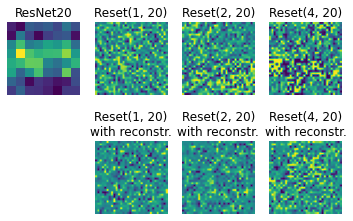

In [ ]:
modelnames = ['ResNet20','CifarNoDecoder1_32','CifarNoDecoder2_32','CifarNoDecoder4_32',
              '', 'NestedCifar1_32','NestedCifar2_32','NestedCifar4_32']
titles = ['ResNet20', 'Reset(1, 20)', 'Reset(2, 20)', 'Reset(4, 20)', 
          '', 'Reset(1, 20)\nwith reconstr.', 'Reset(2, 20)\nwith reconstr.', 'Reset(4, 20)\nwith reconstr.']
datasets = 8*['CIFAR10']
for i, (modelname, dataset, title) in enumerate(zip(modelnames, datasets, titles)):
  if modelname == '':
    plt.axis('off')
  else:
    class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
    print ('class_grid_history.shape',class_grid_history.shape)
    plt.subplot(2,4,i+1);plt.imshow(np.mean(class_grid_history, axis=(0, 1)));plt.axis('off')
    plt.title(title)
plt.savefig('activation_distribution.png', dpi = 300)
plt.show()

In [ ]:
def animate_monitor_focus2(T=None, save=True):
  import numpy as np
  from numpy.ma import masked_array
  import matplotlib.pyplot as plt
  from matplotlib import animation, rc
  from IPython.display import HTML
  from scipy.stats import describe

  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  target_acc_history = np.load(checkpointpath + modelname + dataset + 'target_acc_history.npy')
  target_data_history = np.load(checkpointpath + modelname + dataset + 'target_maps_history.npy') 
  density_history = np.load(checkpointpath + modelname + dataset + 'density_history.npy')
  clustering_history = np.load(checkpointpath + modelname + dataset + 'clustering_history.npy')
  epoch, n, x, y = target_data_history.shape
  
  print ('test_acc_history.shape', test_acc_history.shape)
  print ('target_acc_history.shape', target_acc_history.shape)
  print ('target_data_history.shape', target_data_history.shape)
  print ('density_history.shape', density_history.shape)
  print ('clustering_history.shape', clustering_history.shape)
  print ('describe(target_data_history)', describe(np.ravel(target_data_history)))
  print ('describe(clustering_history)', describe(np.ravel(clustering_history)))
  print ('describe(density_history)', describe(np.ravel(density_history)))

  epochs = np.arange(epoch)
  nans = np.nan*np.zeros(epoch)
  acc_lines, clu_lines, den_lines = 2*[[]], 2*[[]], 2*[[]]
  images = 2*[[]]
  
  #classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  titles = ['animals', 'objects']
  maps = ['Reds', 'Blues']
  colors = ['red', 'blue']
  l = len(titles)

  fig = plt.figure(figsize=(12, 9)) 
  ncols, nrows = 12, 12
  gs = gridspec.GridSpec(nrows, ncols, left=0.05, bottom=0.05, right=0.95, top=0.90, wspace=1, hspace=10)
  # Add axes which can span multiple grid boxes
  ax0 = fig.add_subplot(gs[:3, :4])
  ax1 = fig.add_subplot(gs[:3, 4:8])
  ax2 = fig.add_subplot(gs[:3, 8:12])
  ax3 = fig.add_subplot(gs[3:, :9])
  axleg = fig.add_subplot(gs[3:, 9:12])

  #plt.suptitle(modelname+' '+dataset, size=25)
  ax0.set_title('test accuracy (top 1)', size=20)
  ax0.set_xlabel('epochs', size=13) 
  ax0.set_xlim(0, epoch+1)
  ax0.set_ylim(0,100) 
  #ax1.set_title('clustering index', size=20)
  ax1.set_title('mean cluster size', size=20)
  ax1.set_xlabel('epochs', size=13)
  ax1.set_xlim(0,epoch+1)
  #ax1.set_ylim(0,1) 
  #ax2.set_title('density index', size=20)
  ax2.set_title('mean activation', size=20)
  ax2.set_xlabel('epochs', size=13)
  ax2.set_xlim(0,epoch+1)
  #ax2.set_ylim(0,1) 
  ax3.set_title('vOTC epoch 0', size=20, y=-0.07)
  ax3.tick_params(
          axis='x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=False) # labels along the bottom edge are off
  ax3.tick_params(
          axis='y',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          right=False,         # ticks along the top edge are off
          labelleft=False) # labels along the bottom edge are off
  
  MAX = np.max(target_data_history)
  smooth = True
  if smooth:
    target_acc_history = ndimage.gaussian_filter1d(target_acc_history, 2, axis=0)
    clustering_history = ndimage.gaussian_filter1d(clustering_history, 2, axis=0)
    density_history = ndimage.gaussian_filter1d(density_history, 2, axis=0)
  
  rescale = True
  if rescale:
    clustering_history = (clustering_history - np.min(clustering_history))/(np.max(clustering_history) - np.min(clustering_history))
    density_history = (density_history - np.min(density_history))/(np.max(density_history) - np.min(density_history))

  for i, (title, map, color) in enumerate(zip(titles, maps, colors)):
    # plot: accuracy
    acc_lines[i], = ax0.plot([], [], color=color, lw=2)
    # plot: clustering
    clu_lines[i], = ax1.plot(clustering_history[:, i], color=color, lw=2)
    # plot: density
    den_lines[i], = ax2.plot(density_history[:, i], color=color, lw=2)
    # plot: common map
    data = masked_array(target_data_history[0, i], target_data_history[0, i] < T)
    images[i] = ax3.imshow(data, alpha=0.7, cmap=plt.get_cmap(map), vmin=T, vmax=MAX)

  dummy = ax3.imshow(np.zeros_like(data), alpha=0.5, cmap=plt.get_cmap('Greys'), vmin=T, vmax=MAX) 
  
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  divider = make_axes_locatable(ax3)
  cax = divider.append_axes("right", size="20%", pad=0.05)
  cax.axis('off')
  print ('describe(data)', describe(np.ravel(data)))
  cb = plt.colorbar(dummy, ax=cax)
  cb.set_label("normalized sensitivity (d')", size=20)
  
  
  for i, (cat, color) in enumerate(zip(titles, colors)):
    # Create a Rectangle patch
    rect = patches.Rectangle((0, 0.4 + (i%5)/6.0), 0.2, 0.05, linewidth=1, edgecolor=color, facecolor=color)

    # Add the patch to the Axes
    axleg.add_patch(rect)

    # Annotate
    axleg.annotate(cat, (0.1, 0.415 + (i%5)/6.0), (0.25 + (i//5)/1.5, 0.415 + (i%5)/6.0), size=15)
  axleg.axis('off')
  

  # initialization function: plot the background of each frame
  def init():
    for i in range(l):
      acc_lines[i].set_data([], [])
      clu_lines[i].set_data([], [])
      den_lines[i].set_data([], [])
      images[i].set_array(target_data_history[0, i])
    return acc_lines+images
  
  # animation function. This is called sequentially  
  def animate(t):
    ax3.clear()
    ax3.set_title('vOTC epoch '+str(t), size=20, y=-0.07)
    for i, map in enumerate(maps):
      acc_lines[i].set_data(epochs[:t+1], target_acc_history[:t+1, i])
      clu_lines[i].set_data(epochs[:t+1], clustering_history[:t+1, i])
      den_lines[i].set_data(epochs[:t+1], density_history[:t+1, i])
      update_data = masked_array(target_data_history[t, i], target_data_history[t, i] < T)
      images[i] = ax3.imshow(update_data, alpha=0.7, cmap=plt.get_cmap(map), vmin=T, vmax=MAX)
    return acc_lines+clu_lines+den_lines+images

  frames = np.min((100, epoch))
  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=True)

  if save:
    anim.save(filename='history_monitor_'+modelname+'_'+dataset+'.mp4', fps=10, dpi=300)

  # Note: below is the part which makes it work on Colab
  rc('animation', html='jshtml')
  return anim

In [ ]:
def compute_pipeline2(select1, select2, T = 1, connectivity = 8, gf_sigma=0):
  # compute d-prime sensitivity measure at each point of the grid
  mean1 = np.mean(select1, axis=0)
  mean2 = np.mean(select2, axis=0)
  std1 = np.var(select1, axis=0)**0.5
  std2 = np.var(select2, axis=0)**0.5

  # possibly smooth activations
  gf_sigma = 0#.5
  smean1 = gaussian_filter(mean1, sigma = gf_sigma)   # smoothing
  smean2 = gaussian_filter(mean2, sigma = gf_sigma)   

  # compute d-prime map
  dmap = 2*(smean1 - smean2)/(std1 + std2)

  # compute clustering index

  num_labels, labels, clu_index, select_clu_index, den_index = clustering_index2(dmap, threshold=T, connectivity=connectivity)

  targets_data = dmap #> T
  clustering = clu_index
  density = np.sum(smean1)
  return targets_data, clustering, density

def compute_save_metrics2(modelname=None, dataset=None, T=2, S=0):
  # load data history
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  print ('class_acc_history.shape',class_acc_history.shape)
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  print ('class_grid_history.shape',class_grid_history.shape)

  # initialize arrays 
  n_epochs,_,x,y = np.shape(class_grid_history)
  n_classes = 2
  print ('n_epochs,n_classes,x,y', n_epochs,n_classes,x,y)
  target_maps_history = np.zeros((n_epochs, n_classes, x, y))
  clustering_history = np.zeros((n_epochs, n_classes))
  density_history = np.zeros((n_epochs, n_classes))
  target_acc_history = np.zeros((n_epochs, n_classes))

  # setting parameters for sensitivity and clustering analysis
  connectivity = 4

  # consider a contrast between two sets of classes, here animals vs objects
  set2 = np.array([2, 3, 4, 5, 6, 7]);cat2 = 'animals' 
  set1 = np.array([0, 1, 8, 9]);cat1 = 'objects'
  
  # compute
  for epoch in range(n_epochs):
    select1 = class_grid_history[epoch, set1]
    select2 = class_grid_history[epoch, set2]
    cat = 0
    targets_data, clustering, density = compute_pipeline2(select1, select2, T = T, connectivity = connectivity, gf_sigma=S)
    target_maps_history[epoch, cat] = targets_data
    clustering_history[epoch, cat] = clustering
    density_history[epoch, cat] = density
    target_acc_history[epoch, cat] = np.mean(class_acc_history[epoch,set1])

    cat = 1
    targets_data, clustering, density = compute_pipeline2(select2, select1, T = T, connectivity = connectivity, gf_sigma=S)
    target_maps_history[epoch, cat] = targets_data
    clustering_history[epoch, cat] = clustering
    density_history[epoch, cat] = density
    target_acc_history[epoch, cat] = np.mean(class_acc_history[epoch,set2])

  #save
  np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
  np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
  np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
  np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)

class_acc_history.shape (50, 10)
class_grid_history.shape (50, 10, 8, 8)
n_epochs,n_classes,x,y 50 2 8 8
test_acc_history.shape (51,)
target_acc_history.shape (50, 2)
target_data_history.shape (50, 2, 8, 8)
density_history.shape (50, 2)
clustering_history.shape (50, 2)
describe(target_data_history) DescribeResult(nobs=6400, minmax=(-11.595305118445804, 11.595305118445804), mean=2.498001805406602e-18, variance=4.758323482902722, skewness=-8.558961400891267e-19, kurtosis=2.9517917664336126)
describe(clustering_history) DescribeResult(nobs=100, minmax=(1.0, 14.0), mean=1.7228214285714285, variance=2.3024636402288183, skewness=6.488150382793285, kurtosis=46.151872014882805)
describe(density_history) DescribeResult(nobs=100, minmax=(66.26704147951428, 92.68275516702542), mean=74.4950719761225, variance=31.552121416012994, skewness=1.146935062247625, kurtosis=0.9479866318935657)
describe(data) DescribeResult(nobs=64, minmax=(-11.595305118445804, 8.649561597065238), mean=-0.8208357221014864, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(1.1333333333333333, 7.521739130434782), mean=1.6426429589452674, variance=0.6101723000625389, skewness=6.3703443287764445, kurtosis=41.838013048327724)
describe(density_history) DescribeResult(nobs=102, minmax=(-9.587734865955582, 110.24002080619984), mean=45.265962735429085, variance=921.106786066053, skewness=0.24860935675951623, kurtosis=-0.7705620678613734)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(1.3333333333333333, 5.212121212121212), mean=3.384728274897283, variance=0.5029114710756176, skewness=0.2966090226263621, kurtosis=0.6896095245728144)
describe(density_history) DescribeResult(nobs=102, minmax=(-53.37874153156454, 185.84899124228824), mean=101.02962232324757, variance=3650.9710705720113, skewness=-0.5565524863958602, kurtosis=-0.486579581684635)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(1.56, 7.439024390243903), mean=4.605997197310804, variance=0.767118641942247, skewness=0.008490235722202926, kurtosis=2.08085299339934)
describe(density_history) DescribeResult(nobs=102, minmax=(-26.250020081905383, 120.19123339030207), mean=42.37091209070696, variance=1712.7210137799625, skewness=-0.03149528761379543, kurtosis=-1.3040750940585628)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


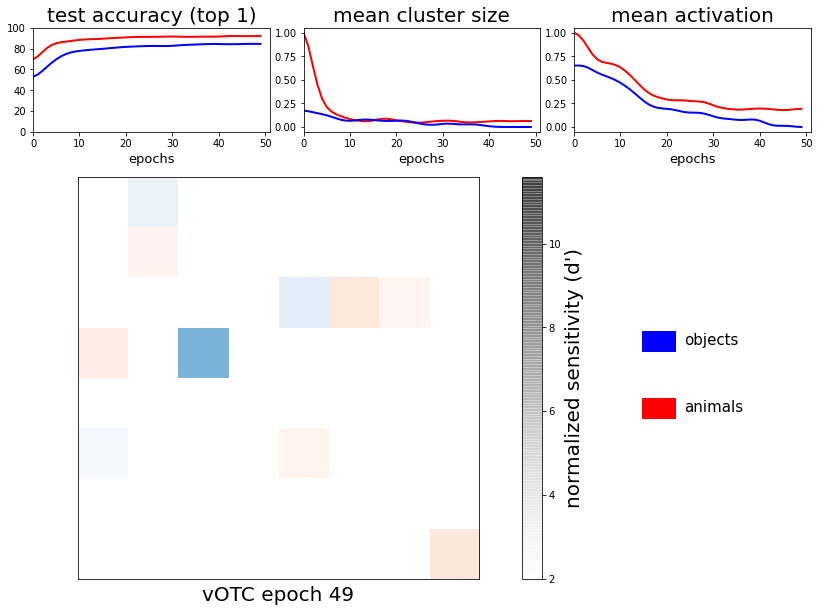

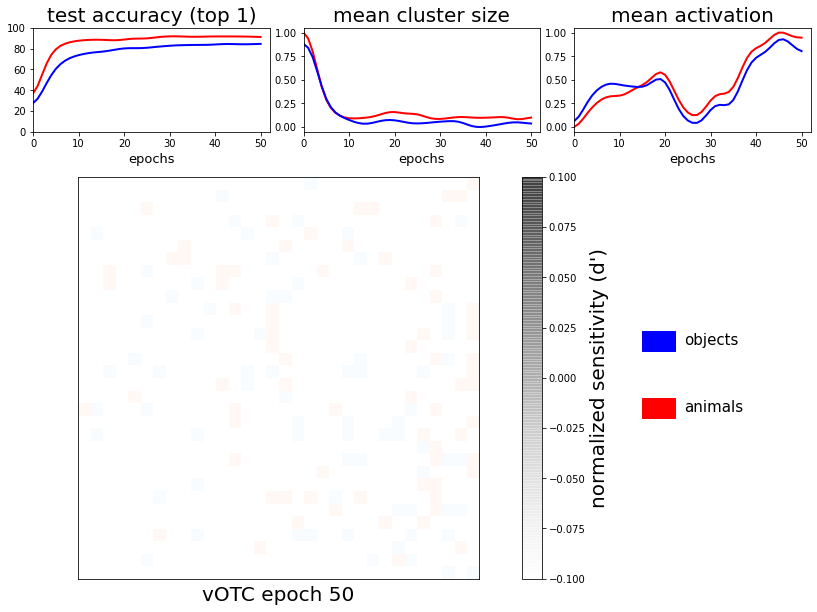

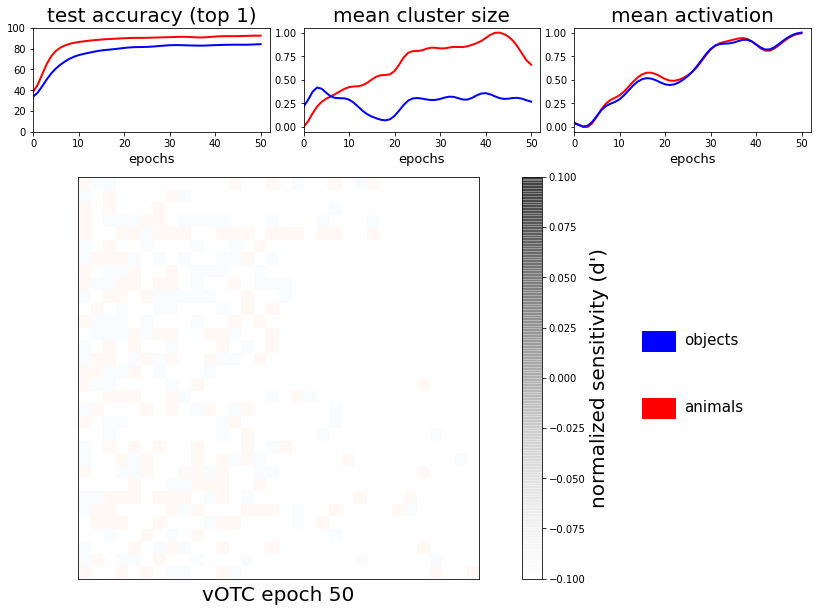

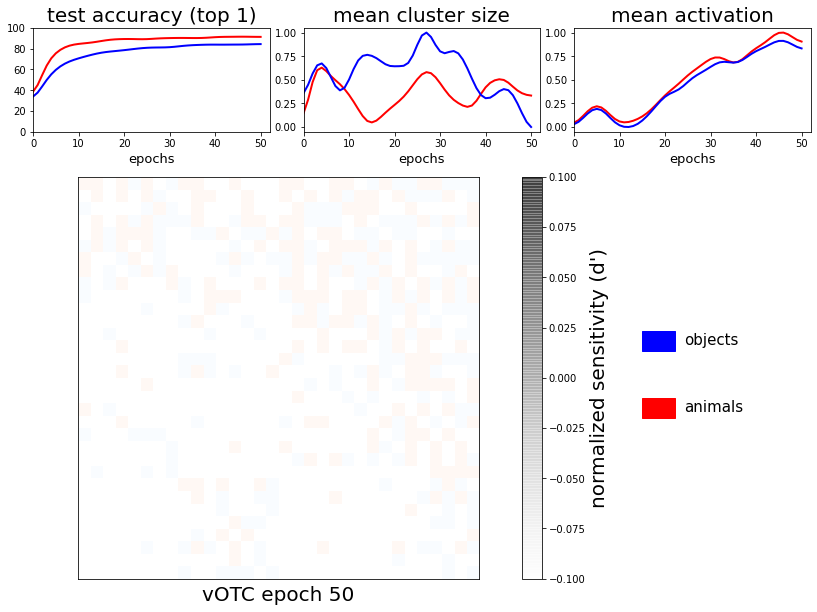

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelnames = ['ResNet20','CifarNoDecoder1_32','CifarNoDecoder2_32','CifarNoDecoder4_32']
datasets = 4*['CIFAR10']
threshold = 2
smoothing = 0
animations = []
for (modelname, dataset) in zip(modelnames, datasets):
  compute_save_metrics2(modelname=modelname, dataset=dataset, T=threshold, S=smoothing)
  animations += [animate_monitor_focus2(T=threshold)]
for anim in animations:
  anim

class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(density_history) DescribeResult(nobs=102, minmax=(-30.49085755190169, 88.78832626819391), mean=17.409243566801052, variance=774.4498255517345, skewness=0.44668512038405683, kurtosis=-0.7293590127635063)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(density_history) DescribeResult(nobs=102, minmax=(-62.71237461606587, 75.00246963068317), mean=5.203979590441595, variance=803.2593366103316, skewness=0.4188037430737654, kurtosis=-0.011179971698533908)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(density_history) DescribeResult(nobs=102, minmax=(-107.97192904627141, 18.532927818585257), mean=-31.22709000634439, variance=950.0187721447437, skewness=-0.48427863514472497, kurtosis=-0.6561896237991474)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(density_history) DescribeResult(nobs=102, minmax=(-9.587734865955582, 110.24002080619984), mean=45.265962735429085, variance=921.106786066053, skewness=0.24860935675951626, kurtosis=-0.7705620678613734)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(density_history) DescribeResult(nobs=102, minmax=(-53.37874153156454, 185.84899124228824), mean=101.02962232324757, variance=3650.9710705720113, skewness=-0.5565524863958602, kurtosis=-0.486579581684635)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class_acc_history.shape (51, 10)
class_grid_history.shape (51, 10, 32, 32)
n_epochs,n_classes,x,y 51 2 32 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test_acc_history.shape (51,)
target_acc_history.shape (51, 2)
target_data_history.shape (51, 2, 32, 32)
density_history.shape (51, 2)
clustering_history.shape (51, 2)
describe(target_data_history) DescribeResult(nobs=104448, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(clustering_history) DescribeResult(nobs=102, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
describe(density_history) DescribeResult(nobs=102, minmax=(-26.250020081905383, 120.19123339030207), mean=42.37091209070695, variance=1712.7210137799625, skewness=-0.031495287613794984, kurtosis=-1.304075094058563)
describe(data) DescribeResult(nobs=1024, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

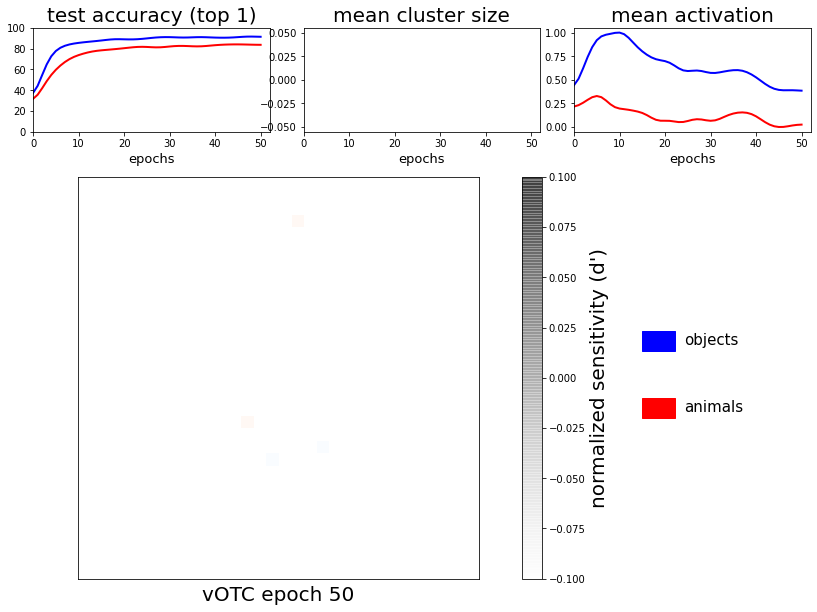

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

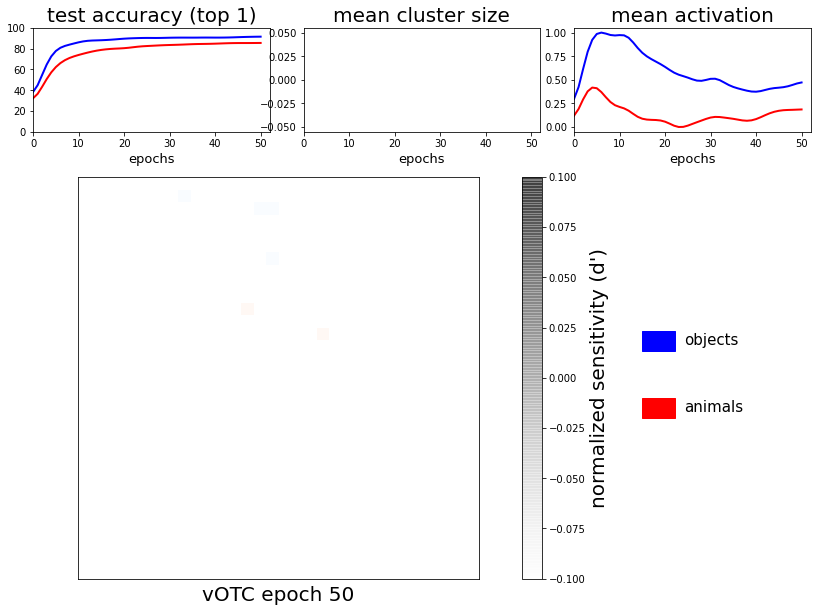

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

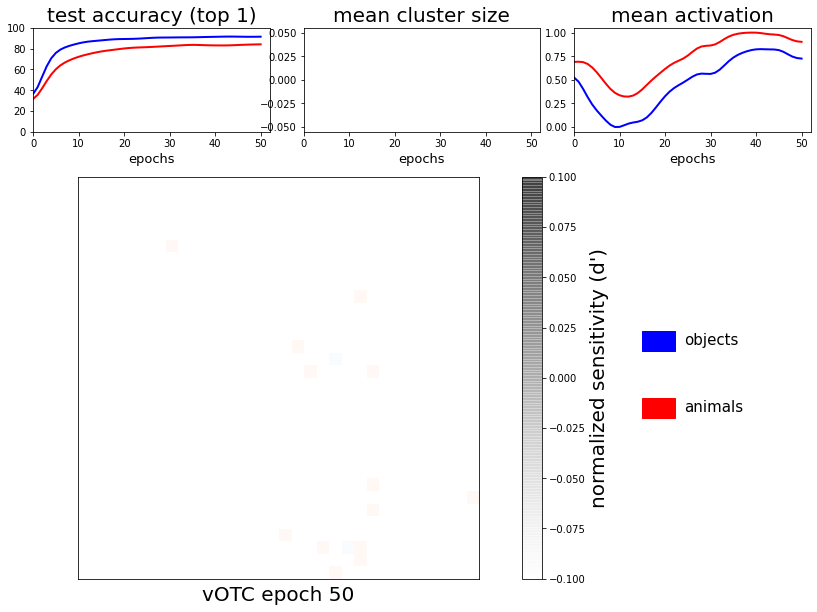

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

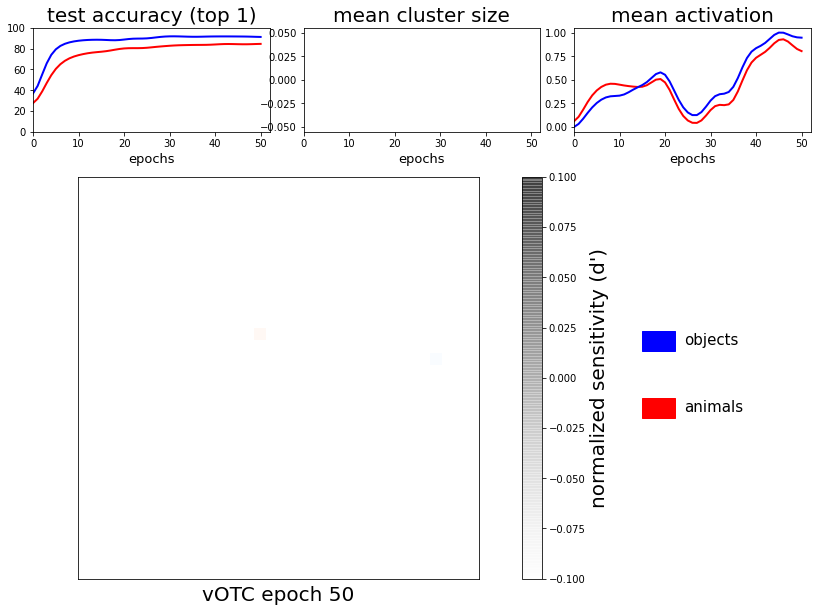

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

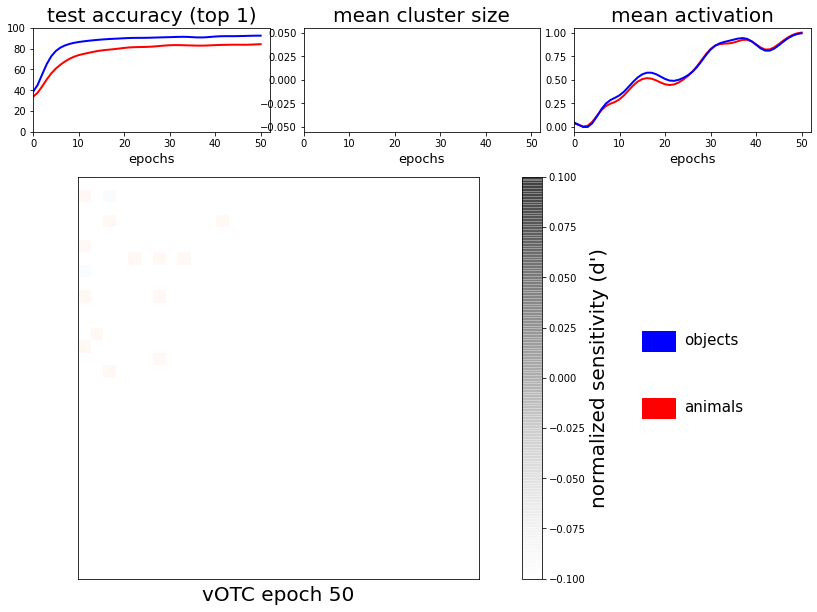

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

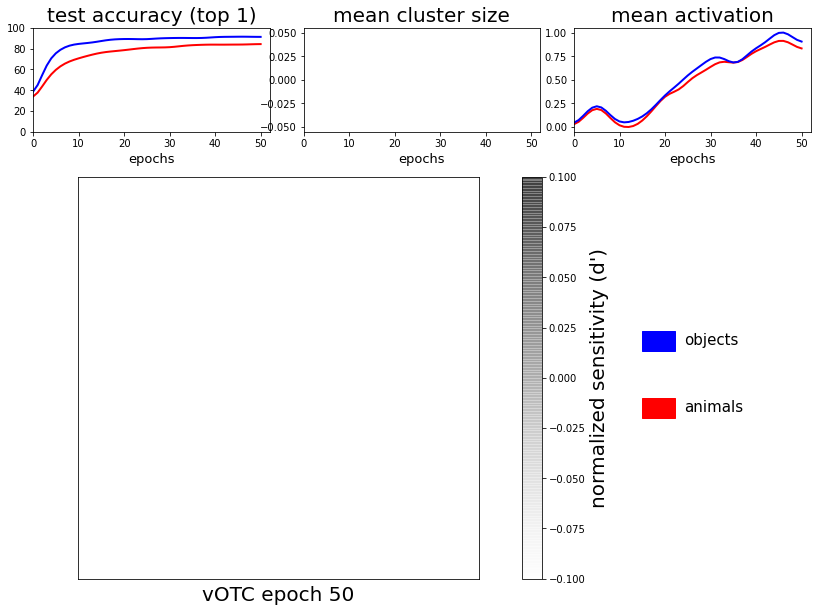

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelnames = ['NestedCifar1_32', 
              'NestedCifar2_32', 
              'NestedCifar4_32', 
              'CifarNoDecoder1_32', 
              'CifarNoDecoder2_32', 
              'CifarNoDecoder4_32']
datasets = 6*['CIFAR10']

#modelnames = ['CifarNoDecoder2_32']
#datasets = ['CIFAR10']
threshold = 0.85
animations = []
for (modelname, dataset) in zip(modelnames, datasets):
  compute_save_metrics(modelname=modelname, dataset=dataset, T=threshold)
  animations += [animate_monitor_focus2(T=threshold)]
for anim in animations:
  anim

Plotting test performance for ResNet20, Reset(4,80), Reset(8,10)

/content/drive/MyDrive/ColabNotebooks/ResNet20CIFAR10test_acc_history.npy
(51,)
/content/drive/MyDrive/ColabNotebooks/NestedCifar1_32CIFAR10test_acc_history.npy
(51,)
(51,)
/content/drive/MyDrive/ColabNotebooks/NestedCifar2_32CIFAR10test_acc_history.npy
(51,)
/content/drive/MyDrive/ColabNotebooks/NestedCifar4_32CIFAR10test_acc_history.npy
(51,)


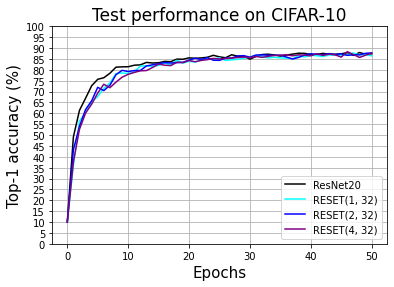

'done'

In [ ]:
def compare_performance_plot(prefix='/content/drive/MyDrive/ColabNotebooks/'):
    r=-1; smooth = 0
    #models = ['ResNet20', 'NestedCifar1', 'NestedCifar2', 'NestedCifar4']
    #names = ['ResNet20', 'RESET(1, 6400)', 'RESET(2, 1600)', 'RESET(4, 400)']
    models = ['ResNet20', 'NestedCifar1_32', 'NestedCifar2_32', 'NestedCifar4_32']
    #models = ['ResNet20', 'CifarNoDecoder1_32', 'CifarNoDecoder2_32', 'CifarNoDecoder4_32']
    names = ['ResNet20', 'RESET(1, 32)', 'RESET(2, 32)', 'RESET(4, 32)']
    datasets = ['CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10']
    colors = ['black', 'cyan', 'blue', 'purple']
    for i, (model, name, dataset, color) in enumerate(zip(models, names, datasets, colors)):
      print (prefix+model+dataset+'test_acc_history.npy')
      if i == 1:
        data = np.load('/content/drive/MyDrive/ColabNotebooks/CifarNoDecoder1_32CIFAR10test_acc_history.npy');print(data.shape)
      if i == 2:
        data = np.load('/content/drive/MyDrive/ColabNotebooks/CifarNoDecoder2_32CIFAR10test_acc_history.npy');print(data.shape)
      else:
        data = np.load(prefix+model+dataset+'test_acc_history.npy');print(data.shape)
      if smooth > 0:
          data = ndimage.gaussian_filter1d(data[:r], smooth, 0)
      #plt.plot(test_x, test_y, label=model)
      plt.plot(data, label=name, c=color)
    l = len(data);y = np.arange(0,101,5);labels=[str(i) for i in y]
    plt.yticks(y, labels)
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Top-1 accuracy (%)', size=15)
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)
    title = 'Test performance on CIFAR-10'
    plt.title(title, size= 17)
    plt.savefig(title+'.png', dpi = 300)
    plt.show()
    return 'done'
compare_performance_plot()

In [ ]:
data = np.load('/content/drive/MyDrive/ColabNotebooks/CifarNoDecoder1_32CIFAR10test_acc_history.npy');print(data.shape)

(51,)


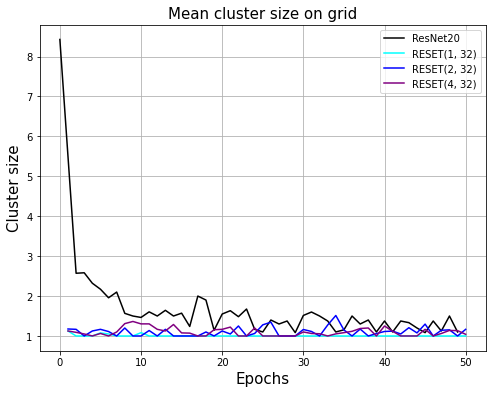

'done'

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
def compare_clustering_plot(prefix='/content/drive/MyDrive/ColabNotebooks/'):
    plt.figure(figsize=(8,6))
    r=-1; smooth = 0
    models = ['ResNet20', 'NestedCifar1_32', 'NestedCifar2_32', 'NestedCifar4_32']
    #models = ['ResNet20', 'CifarNoDecoder1_32', 'CifarNoDecoder2_32', 'CifarNoDecoder4_32']
    names = ['ResNet20', 'RESET(1, 32)', 'RESET(2, 32)', 'RESET(4, 32)']
    datasets = ['CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10']
    colors = ['black', 'cyan', 'blue', 'purple']
    for i, (model, name, dataset, color) in enumerate(zip(models, names, datasets, colors)):
      if i >= 0:
        density_history = np.load(checkpointpath + model + dataset + 'density_history.npy')
        data = np.load(checkpointpath + model + dataset + 'clustering_history.npy')
        #data = (data - np.min(data))/(np.max(data) - np.min(data))
        data = np.mean(data, axis=1)
        #data = np.mean(density_history, axis=1)
        #data = np.mean(clustering_history, axis=1)*np.mean(density_history, axis=1)
        if smooth > 0:
            data = ndimage.gaussian_filter1d(data[:r], smooth, 0)
        #plt.plot(test_x, test_y, label=model)
        plt.plot(data, label=name, c=color)
    l = len(data);y = np.linspace(0,1,11);labels=[str(i) for i in y]
    #plt.yticks(y, labels)
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Cluster size', size=15)
    #plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    title = 'Mean cluster size on grid'
    plt.title(title, size= 15)
    plt.savefig(title+'.png', dpi = 300)
    plt.show()
    return 'done'
compare_clustering_plot()

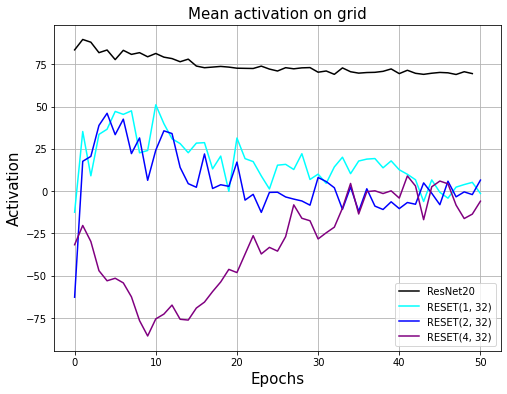

'done'

In [ ]:
def compare_density_plot(prefix='/content/drive/MyDrive/ColabNotebooks/'):
    r=-1; smooth = 0
    plt.figure(figsize=(8,6))
    models = ['ResNet20', 'NestedCifar1_32', 'NestedCifar2_32', 'NestedCifar4_32']
    #models = ['ResNet20', 'CifarNoDecoder1_32', 'CifarNoDecoder2_32', 'CifarNoDecoder4_32']
    names = ['ResNet20', 'RESET(1, 32)', 'RESET(2, 32)', 'RESET(4, 32)']
    datasets = ['CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10']
    colors = ['black', 'cyan', 'blue', 'purple']
    for i, (model, name, dataset, color) in enumerate(zip(models, names, datasets, colors)):
      if i >= 0:
        data = np.load(checkpointpath + model + dataset + 'density_history.npy')
        #data = (data - np.min(data))/(np.max(data) - np.min(data))
        data = np.mean(data, axis=1)
        #data = np.mean(clustering_history, axis=1)*np.mean(density_history, axis=1)
        if smooth > 0:
            data = ndimage.gaussian_filter1d(data[:r], smooth, 0)
        plt.plot(data, label=name, c=color)
    l = len(data);y = np.linspace(0,1,11);labels=[str(i) for i in y]
    #plt.yticks(y, labels)
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Activation', size=15)
    #plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    title = 'Mean activation on grid'
    plt.title(title, size= 15)
    plt.savefig(title+'.png', dpi = 300)
    plt.show()
    return 'done'
compare_density_plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

classes[index], mean: dog -0.06099469
classes[index], mean: ship -0.4223567
classes[index], mean: cat -0.25894102
classes[index], mean: bird -0.09645855
classes[index], mean: bird 0.2716135
classes[index], mean: plane -0.21244518
classes[index], mean: car -0.45454872
classes[index], mean: car -0.21575834
classes[index], mean: cat -0.736849
classes[index], mean: horse -0.46332526


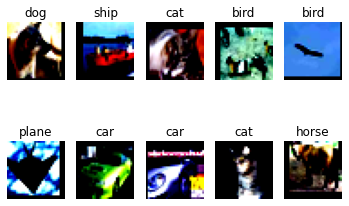

In [ ]:
train_iter = iter(trainloader)
images, labels = train_iter.next()
for i in np.arange(10):
  index = int(labels[i].numpy())
  plt.subplot(2,5,i+1)
  plt.title(classes[index])
  plt.axis('off')
  im = np.moveaxis(images[i].numpy(), 0,2)
  plt.imshow(im)
  print ('classes[index], mean:', classes[index], np.mean(im))
plt.savefig('CIFAR_10.png', dpi = 300)
plt.show()

In [ ]:
#test autoencoder classifier
def test_auto_class(net, testloader):
  net.eval()
  start = time.time()
  net.to(device)
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          grid, outputs_class, outputs_auto = net(inputs)
  return inputs.detach().cpu().numpy(), grid.detach().cpu().numpy(), outputs_class.detach().cpu().numpy(), outputs_auto.detach().cpu().numpy()

In [ ]:
#call test autoencoder classifier
testacc = test(net, testloader)
inputs, grid, outputs_class, outputs_auto = test_auto_class(net, testloader)

Accuracy of the network on the  10000 test images: 87.65
Test time: 00:00:02
n


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min, max 0.0 0.0


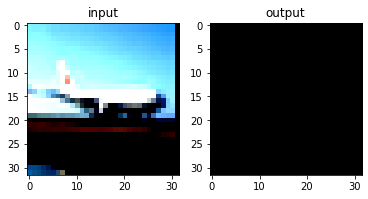

In [ ]:
import scipy
#visualize autoencoder outputs
index = 4
inp = inputs[index]
out = outputs_auto[index]
inp = np.swapaxes(inp, 2, 0)
out = np.swapaxes(out, 2, 0)
inp = np.swapaxes(inp, 0, 1)
out = np.swapaxes(out, 0, 1)

_, (min,max), _, _, _, _ = scipy.stats.describe(np.ravel(out))
print ('min, max', min, max)
"""
if min !=0:
  out = (out - min)/(max-min)
else:
  out = out/max
"""
plt.subplot(121)
plt.imshow(inp)
plt.title('input')
plt.subplot(122)
plt.imshow(out)
plt.title('output')
plt.savefig('reconstruction.png', dpi = 300)
plt.show()

Files already downloaded and verified
Nested cortical networks for CIFAR loaded
==> Model built. The model has  1294959 total parameters
This network had 245 stored sets of parameters
Pretrained weights loaded
Nested cortical networks for CIFAR loaded
==> Model built. The model has  2102175 total parameters
Nested cortical networks for CIFAR loaded
==> Model built. The model has  5331039 total parameters
min, max -1.9719775 2.115549
min, max 0.0 1.377877e-25
min, max 0.48361948 0.55584866
min, max 0.4438638 0.5036281


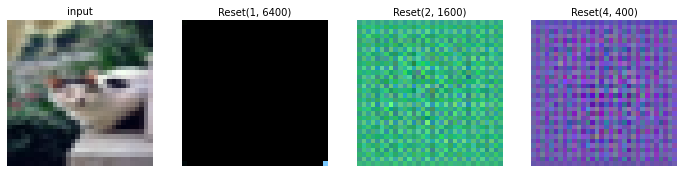

In [ ]:
#Visualize autoencoder output (reconstruction of the input from the grid) for different models
# input, Reset(1, 6400), Reset(2, 1600), Reset(4, 400)
load_models= True
recompute=True
import scipy

# reload test loader
transform = transforms.Compose(
      [transforms.Resize(32),
       transforms.ToTensor(),
       transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize,
                                          shuffle=False, num_workers=1)

if load_models:
  # load the 3 models.
  Reset_1_6400 = load_Model(checkpointpath=checkpointpath, modelname='NestedCifar1_32', dataset='CIFAR10', load_model=True,
                            input_channels=3, gridsize=1, n_classes1=1024, n_classes2=10)
  Reset_2_1600 = load_Model(checkpointpath=checkpointpath, modelname='NestedCifar2_32', dataset='CIFAR10', load_model=False, 
                            input_channels=3, gridsize=2, n_classes1=256, n_classes2=10)
  Reset_4_400 = load_Model(checkpointpath=checkpointpath, modelname='NestedCifar4_32', dataset='CIFAR10', load_model=False,
                            input_channels=3, gridsize=4, n_classes1=64, n_classes2=10)

if recompute:
  # for each model, compute reconstruction.
  inputs, grid_1_6400, outputs_class_1_6400, outputs_auto_1_6400 = test_auto_class(Reset_1_6400, testloader)
  _, grid_2_1600, outputs_class_2_1600, outputs_auto_2_1600 = test_auto_class(Reset_2_1600, testloader)
  _, grid_4_400, outputs_class_4_400, outputs_auto_4_400 = test_auto_class(Reset_4_400, testloader)

# plot input along with reconstructions.
#visualize autoencoder outputs
index = 1
reconstructions = [inputs, outputs_auto_1_6400, outputs_auto_2_1600, outputs_auto_4_400]
titles = ['input', 'Reset(1, 6400)', 'Reset(2, 1600)', 'Reset(4, 400)'] 
plt.figure(figsize=(12,3))
for i, (recon, title) in enumerate(zip(reconstructions, titles)):
  data = recon[index]
  data = np.swapaxes(data, 2, 0)
  data = np.swapaxes(data, 0, 1)
  _, (min,max), _, _, _, _ = scipy.stats.describe(np.ravel(data))
  print ('min, max', min, max)
  if min !=0:
    data = (data - min)/(max-min)
  else:
    data = data/max
  plt.subplot(1, 4, i+1)
  plt.imshow(data)
  plt.title(title, size=10)
  plt.axis('off')
plt.savefig('compare_reconstructions.png', dpi = 300)
plt.show()